In [5]:
## Imports of all the libraries and dependencies 
import pandas as pd
import holidays
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [6]:
## Loading Datasets
transactions = pd.read_csv('transactions.csv',parse_dates=['doj','doi'])

transactions_dbd_15 = transactions[transactions['dbd']==15].copy()

In [7]:

region_map = {
    'Karnataka': 'KA',
    'Tamil Nadu': 'TN',
    'Andhra Pradesh': 'AP',
    'Maharashtra and Goa': 'MH',  # Assign MH for now
    'Kerala': 'KL',
    'Delhi': 'DL',
    'Madhya Pradesh': 'MP',
    'Rajasthan': 'RJ',
    'Rest of North': 'UP',        # Representative for North
    'East 1': 'WB',               # Use West Bengal for East region
}


def add_holiday_flags(df):

    # Map region names to state codes
    df['state_src'] = df['srcid_region'].map(region_map)
    df['state_dest'] = df['destid_region'].map(region_map)
    
    # Build holiday cache
    unique_states = pd.unique(df[['state_src', 'state_dest']].values.ravel())
    holiday_cache = {
        state: set(holidays.CountryHoliday('IN', prov=state).keys())
        for state in unique_states if pd.notna(state)
    }
    
    # Add holiday flags
    df['is_holiday_src'] = df.apply(
        lambda r: int(r['doj'].date() in holiday_cache.get(r['state_src'], set())), axis=1
    ).astype('int8')

    df['is_holiday_dest'] = df.apply(
        lambda r: int(r['doj'].date() in holiday_cache.get(r['state_dest'], set())), axis=1
    ).astype('int8')
    
    return df

def data_extraction_doj(df):

    df = df.dropna(subset=['doj'])

    # Extract features
    df['day_of_week'] = df['doj'].dt.weekday
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['month'] = df['doj'].dt.month.astype(int)
    df['week'] = df['doj'].dt.isocalendar().week.astype(int)

    return df



In [8]:
import pandas as pd
import holidays

def add_is_national_holiday_flag(df):
    # Ensure DOJ is datetime
    df['doj'] = pd.to_datetime(df['doj'])

    # Define range of years to include
    years = [2023, 2024, 2025]

    # Load Indian holidays for the given years
    india_holidays = set()
    for year in years:
        india_holidays.update(holidays.India(years=year).keys())

    # Flag whether each DOJ is a national holiday
    df['is_national_holiday'] = df['doj'].dt.date.isin(india_holidays).astype('int8')

    return df


import pandas as pd
import holidays
from datetime import timedelta

def add_long_weekend_flag(df):
    # Ensure DOJ is datetime
    df['doj'] = pd.to_datetime(df['doj'])

    # Holiday set for 2023, 2024, 2025
    india_holidays = set()
    for year in [2023, 2024, 2025]:
        india_holidays.update(holidays.India(years=year).keys())

    india_holidays = sorted(india_holidays)

    # Precompute holiday + adjacent days
    holiday_dates = set(india_holidays)
    prev_day = set(h - timedelta(days=1) for h in india_holidays)
    next_day = set(h + timedelta(days=1) for h in india_holidays)

    # Long weekend logic
    def is_long_weekend(date):
        dow = date.weekday()  # 0 = Monday, ..., 6 = Sunday
        if date in holiday_dates and dow in [4, 5, 6, 0]:  # Fri–Mon holiday
            return 1
        if date in prev_day and (date + timedelta(days=1)) in holiday_dates and date.weekday() == 6:
            return 1  # Sunday before Monday holiday
        if date in next_day and (date - timedelta(days=1)) in holiday_dates and date.weekday() == 4:
            return 1  # Friday before Saturday holiday
        return 0

    df['is_long_weekend'] = df['doj'].dt.date.apply(is_long_weekend).astype('int8')
    return df


In [9]:
def generate_features(df):
    return df.groupby(['srcid', 'destid', 'doj'], observed=True).agg(
        cumsum_seatcount=('cumsum_seatcount', 'mean'),
        cumsum_searchcount=('cumsum_searchcount', 'mean'),
        day_of_week=('day_of_week', 'first'),
        is_weekend=('is_weekend', 'first'),
        month=('month', 'first'),
        # is_holiday_src=('is_holiday_src', 'max'),
        # is_holiday_dest=('is_holiday_dest', 'max'),
        is_national_holiday=('is_national_holiday', 'max'),
        is_long_weekend=('is_long_weekend', 'max'),
        week=('week', 'first'),
        state_src = ('state_src', 'first'),
    	state_dest = ('state_dest', 'first'),
    ).reset_index()



# Function to merge features with the base DataFrame
def merge_features(features_df, base_df, keys=['srcid', 'destid', 'doj'],drop_columns=None):
    merged_df = base_df.merge(features_df, on=keys, how='left')
    if drop_columns:
        merged_df = merged_df.drop(columns=drop_columns, errors='ignore')
    return merged_df


In [10]:

def label_encode(df):
    df = df.copy()
    for col in df.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def fill_na_with_mean(df):

    df = df.copy()
    numeric_cols = df.select_dtypes(include='number')
    means = numeric_cols.mean()
    return df.fillna(means)



In [11]:
## Transction Data Preprocessing
transactions_dbd_15 = add_is_national_holiday_flag(transactions_dbd_15)
transactions_dbd_15 = add_holiday_flags(transactions_dbd_15)
transactions_dbd_15 = add_long_weekend_flag(transactions_dbd_15)
transactions_dbd_15 = data_extraction_doj(transactions_dbd_15)
features = generate_features(transactions_dbd_15)

In [12]:
train = pd.read_csv('train.csv', parse_dates=['doj'])
train = merge_features(features, train, drop_columns=['doj'])
train = label_encode(train)
train = fill_na_with_mean(train)


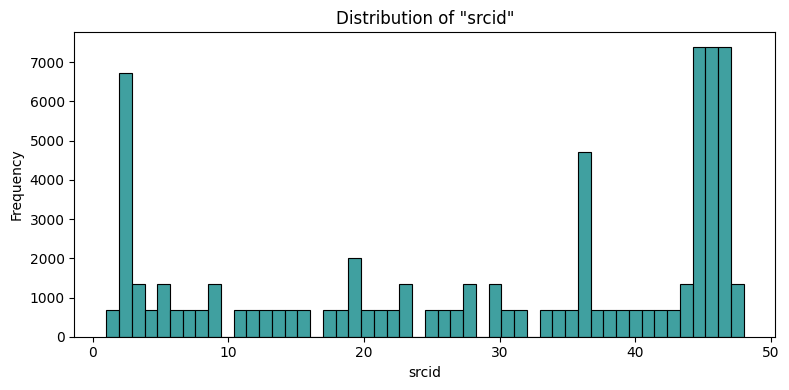

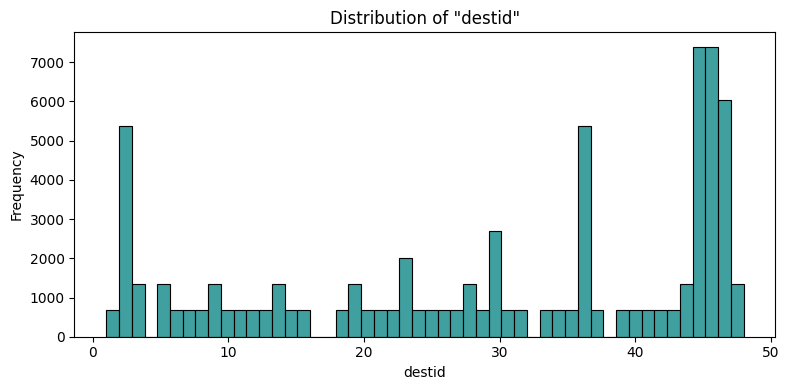

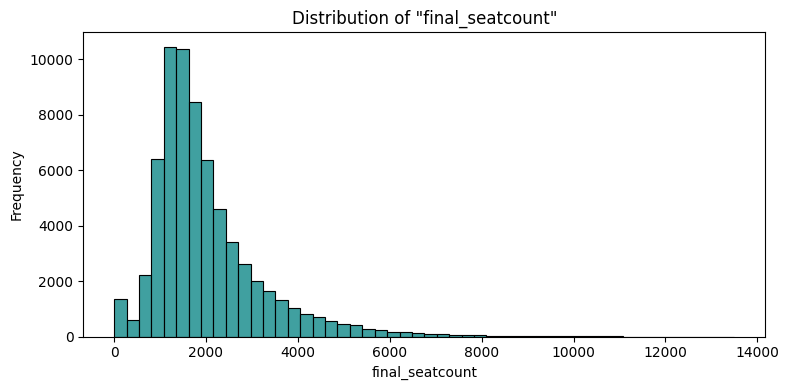

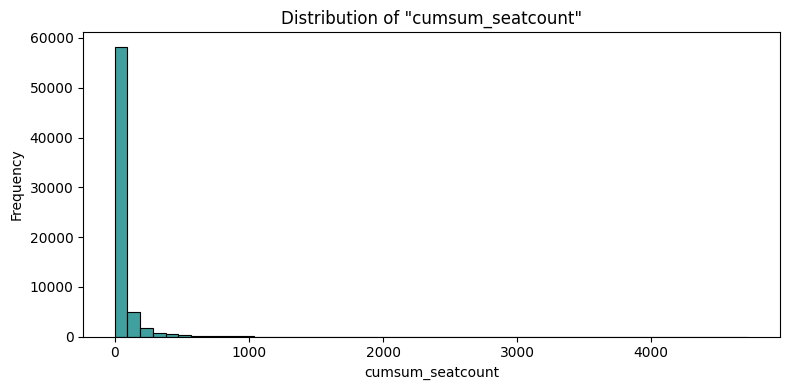

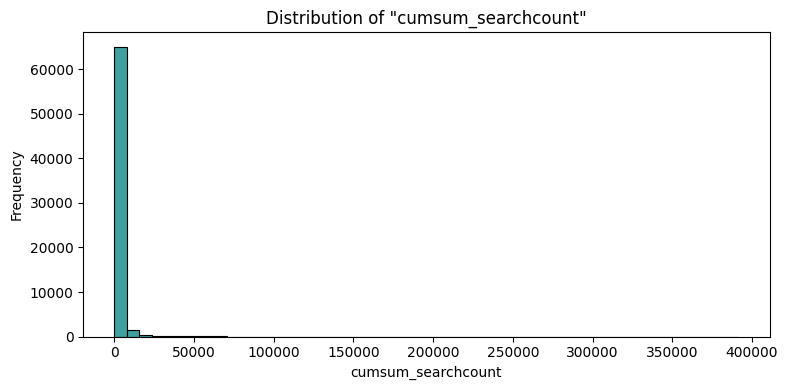

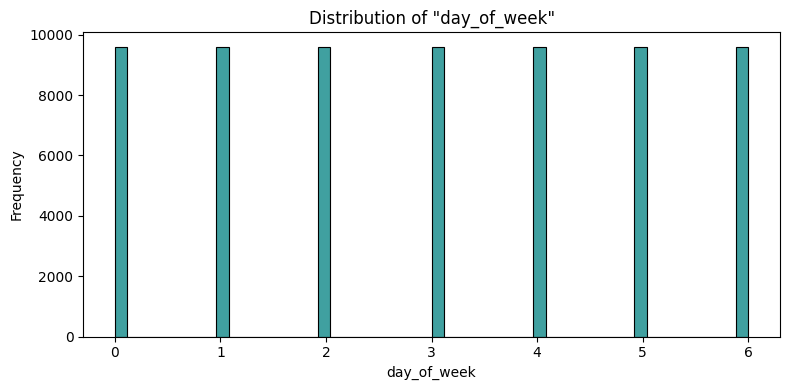

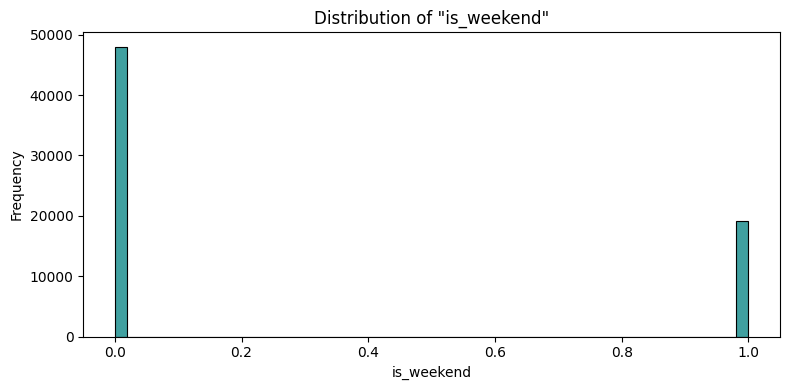

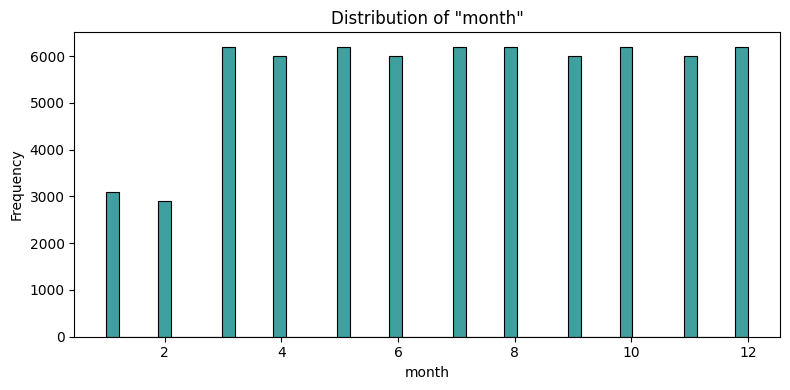

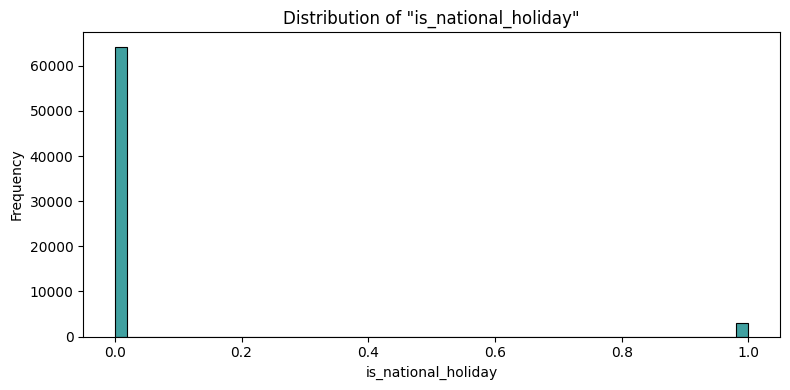

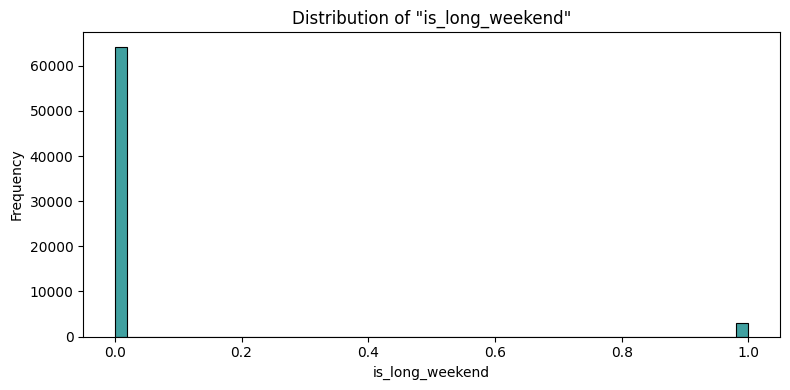

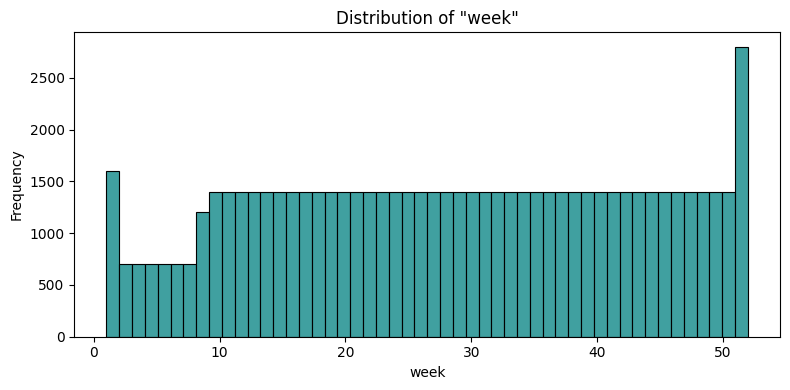

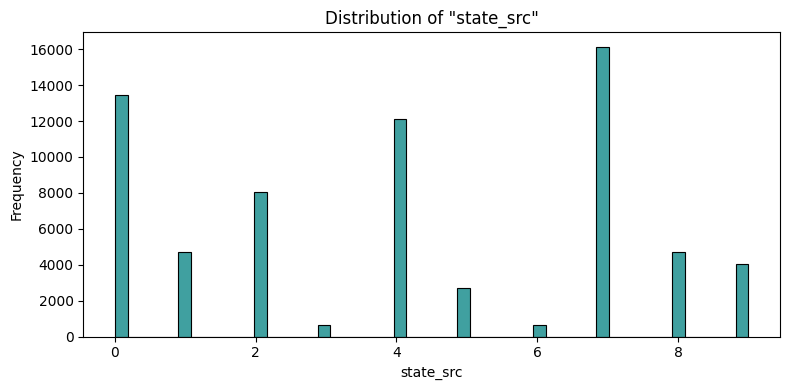

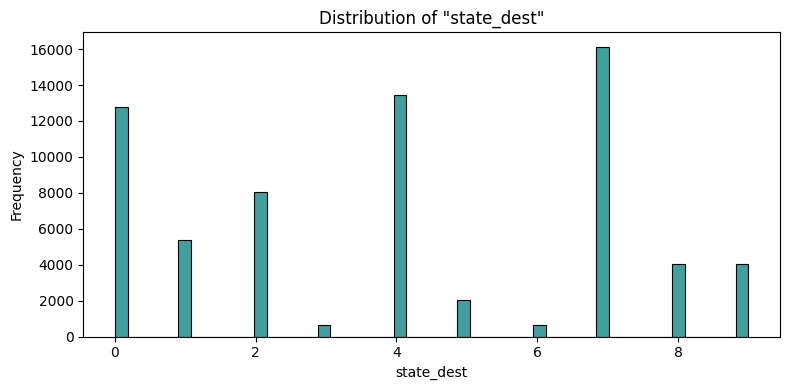

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms_for_numeric_columns(df, bins=50):
    """
    Plots histograms for all numeric columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        bins (int): Number of bins to use for histograms.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), bins=bins, kde=False, color='teal')
        plt.title(f'Distribution of "{col}"')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()


plot_histograms_for_numeric_columns(train)

In [14]:
X = train.drop(columns=['final_seatcount'])
y = train['final_seatcount']

In [15]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Params
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt'
}

# Prepare dict to store evals
evals_result = {}

# Train model with evals_result tracking
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
        lgb.record_evaluation(evals_result)
    ]
)

# Best iteration
best_iter = model.best_iteration

# Extract RMSEs
train_rmse = evals_result['train']['rmse'][best_iter - 1]
val_rmse = evals_result['val']['rmse'][best_iter - 1]

# Output
print(f"✅ RMSE at best iteration ({best_iter}):")
print(f"   - Training RMSE: {train_rmse:.4f}")
print(f"   - Validation RMSE: {val_rmse:.4f}")


Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 431.521	val's rmse: 447.785
[200]	train's rmse: 388.283	val's rmse: 415.845
[300]	train's rmse: 366.282	val's rmse: 402.667
[400]	train's rmse: 350.153	val's rmse: 395.768
[500]	train's rmse: 337.542	val's rmse: 390.12
[600]	train's rmse: 327.531	val's rmse: 387.341
[700]	train's rmse: 318.648	val's rmse: 383.89
[800]	train's rmse: 310.583	val's rmse: 381.24
[900]	train's rmse: 303.66	val's rmse: 379.857
[1000]	train's rmse: 297.15	val's rmse: 378.132
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 297.15	val's rmse: 378.132
✅ RMSE at best iteration (1000):
   - Training RMSE: 297.1497
   - Validation RMSE: 378.1320


In [16]:
# Prepare LightGBM dataset on full data
full_data = lgb.Dataset(X, label=y)

# Train final model with best number of boosting rounds
lgb_final_model = lgb.train(
    params,
    full_data,
    num_boost_round=best_iter
)



In [17]:
test = pd.read_csv('test.csv', parse_dates=['doj'])
routekey = test['route_key'].copy()
test = merge_features(features, test, drop_columns=['doj', 'route_key'])
test = label_encode(test)
test = fill_na_with_mean(test)




## Prediction
y_pred = lgb_final_model.predict(test).astype('int')

## Step 8: Save predictions in the given submission file format
submission = pd.DataFrame({'route_key': routekey, 'final_seatcount': y_pred})
submission.to_csv('predictions.csv', index=False)
print(f'Saved predictions.csv with {len(submission)} rows.')

Saved predictions.csv with 5900 rows.
